In [1]:
import os
import glob
import time

import PIL
import imageio
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers
from IPython import display
import matplotlib.pyplot as plt
%matplotlib inline

print("tensorflow",tf.__version__)

tensorflow 2.0.0


In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_x,_),(test_x,_) = fashion_mnist.load_data()

In [3]:
print("max pixel : ",train_x.max())
print("min pixel : ",train_x.min())

max pixel :  255
min pixel :  0


### 데이터 전처리

In [4]:
train_x = (train_x - 127.5) / 127.5
print("max pixel : ",train_x.max())
print("min pixel : ",train_x.min())

max pixel :  1.0
min pixel :  -1.0


In [5]:
train_x = train_x.reshape(train_x.shape[0],28,28,1).astype('float32')
train_x.shape

(60000, 28, 28, 1)

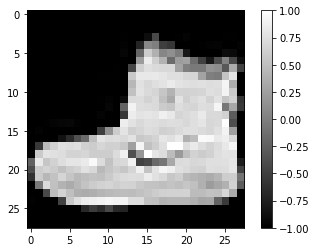

In [6]:
#첫번째 이미지가 꺼내보기
plt.imshow(train_x[0].reshape(28,28),cmap='gray')
plt.colorbar()
plt.show()

In [7]:
BUFFER_SIZE = 60000
BATCH_SIZE = 256

In [8]:
train_dataset = tf.data.Dataset.from_tensor_slices(train_x).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

2023-01-17 15:56:04.340725: I tensorflow/core/platform/cpu_feature_guard.cc:145] This TensorFlow binary is optimized with Intel(R) MKL-DNN to use the following CPU instructions in performance critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in non-MKL-DNN operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-17 15:56:04.341089: I tensorflow/core/common_runtime/process_util.cc:115] Creating new thread pool with default inter op setting: 8. Tune using inter_op_parallelism_threads for best performance.


# Generator 구현하기

In [9]:
def make_generator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Dense layer
    model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Second: Reshape layer
    model.add(layers.Reshape((7, 7, 256)))

    # Third: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(128, kernel_size=(5, 5), strides=(1, 1), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fourth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(64, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False))
    model.add(layers.BatchNormalization())
    model.add(layers.LeakyReLU())

    # Fifth: Conv2DTranspose layer
    model.add(layers.Conv2DTranspose(1, kernel_size=(5, 5), strides=(2, 2), padding='same', use_bias=False, \
                                     activation='tanh'))

    return model

In [10]:
generator = make_generator_model()
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 12544)             1254400   
_________________________________________________________________
batch_normalization (BatchNo (None, 12544)             50176     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 12544)             0         
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 256)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 7, 7, 128)         819200    
_________________________________________________________________
batch_normalization_1 (Batch (None, 7, 7, 128)         512       
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7, 7, 128)         0

In [11]:
noise = tf.random.normal([1,100])

In [12]:
generated_image = generator(noise,training=False)
generated_image.shape

TensorShape([1, 28, 28, 1])

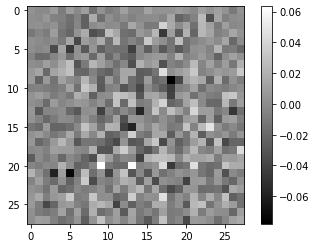

In [13]:
plt.imshow(generated_image[0,:,:,0],cmap='gray')
plt.colorbar()
plt.show()

# discriminator 구현하기

In [14]:
def make_discriminator_model():

    # Start
    model = tf.keras.Sequential()

    # First: Conv2D Layer
    model.add(layers.Conv2D(64, (5, 5), strides=(2, 2), padding='same', input_shape=[28, 28, 1]))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Second: Conv2D Layer
    model.add(layers.Conv2D(128, (5, 5), strides=(2, 2), padding='same'))
    model.add(layers.LeakyReLU())
    model.add(layers.Dropout(0.3))

    # Third: Flatten Layer
    model.add(layers.Flatten())

    # Fourth: Dense Layer
    model.add(layers.Dense(1))

    return model

In [15]:
discriminator = make_discriminator_model()

discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_4 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

In [16]:
decision = discriminator(generated_image, training=False)
decision

<tf.Tensor: id=777, shape=(1, 1), dtype=float32, numpy=array([[-0.00108108]], dtype=float32)>

# loss 함수

In [17]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [18]:
def generator_loss(fake_output):
    return cross_entropy(tf.ones_like(fake_output),fake_output)

In [19]:
def discriminator_loss(real_output,fake_output):
    real_loss = cross_entropy(tf.ones_like(real_output),real_output)
    fake_loss = cross_entropy(tf.zeros_like(fake_output),fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

In [20]:
def discriminator_accuracy(real_output, fake_output):
    real_accuracy = tf.reduce_mean(tf.cast(tf.math.greater_equal(real_output, tf.constant([0.5])), tf.float32))
    fake_accuracy = tf.reduce_mean(tf.cast(tf.math.less(fake_output, tf.constant([0.5])), tf.float32))
    return real_accuracy, fake_accuracy

In [21]:
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

In [22]:
noise_dim = 100
num_examples_to_generate = 16

seed = tf.random.normal([num_examples_to_generate, noise_dim])
seed.shape

TensorShape([16, 100])

# 훈련과정 설계

### 기본 훈련 과정

In [23]:
def train_step(images):
    noise = tf.random.normal([BATCH_SIZE,noise_dim])
    
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_images = generator(noise,training=True) #처음의 noise를 가지고 이미지를 생성한다.
        
        #discriminator로 판별
        real_output = discriminator(images,training=True)
        fake_output = discriminator(generated_images,training=True)
        
        #loss 계산
        gen_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output,fake_output)
        
        #accuracy 계산
        real_accuracy,fake_accuracy = discriminator_accuracy(real_output,fake_output)
    
    #gradient 계산
    gradients_of_generator = gen_tape.gradient(gen_loss,generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss,discriminator.trainable_variables)
    
    #train model
    generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator,discriminator.trainable_variables))
    
    return gen_loss,disc_loss,real_accuracy,fake_accuracy

### 학습 현황을 볼 수 있는 샘플을 생성하는 함수

In [24]:
def generate_and_save_images(model,epoch,it,sample_seeds):
    
    predictions = model(sample_seeds,training=False)
    
    fig = plt.figure(figsize=(4,4))
    for i in range(predictions.shape[0]):
        plt.subplot(4,4,i+1)
        plt.imshow(predictions[i,:,:,0],cmap='gray')
        plt.axis('off')
        
    plt.savefig('./fashion/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                    .format(epoch, it))
    plt.show()

###  loss와 accuracy 그래프

In [25]:
from matplotlib.pylab import rcParams
rcParams['figure.figsize'] = 15,6

def draw_train_history(history,epoch):
    #history for loss
    plt.subplot(211)
    plt.plot(history['gen_loss'])
    plt.plot(history['disc_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('batch iters')
    plt.legend(['gen_loss','disc_loss'],loc='upper left')
    
    #history for accuracy
    plt.subplot(212)
    plt.plot(history['fake_accuracy'])
    plt.plot(history['real_accuracy'])
    plt.title('discriminator accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('batch iters')
    plt.legend(['fake_accuracy','real_accuracy'],loc='upper left')
    
    plt.savefig('./fashion/training_history/train_history_{:04d}.png'.format(epoch))
    plt.show()

### 모델을 저장하기 위한 checkpoint

In [26]:
checkpoint_dir = "./fashion/training_checkpoints"
checkpoint_prefix = os.path.join(checkpoint_dir,'ckpt')
checkpoint = tf.train.Checkpoint(generator_optimizer=generator_optimizer,
                                discriminator_optimizer=discriminator_optimizer,
                                generator = generator,
                                discriminator=discriminator)

# 학습시키기

In [27]:
def train(dataset, epochs, save_every):
    start = time.time()
    history = {'gen_loss':[], 'disc_loss':[], 'real_accuracy':[], 'fake_accuracy':[]}

    for epoch in range(epochs):
        epoch_start = time.time()
        for it, image_batch in enumerate(dataset):
            gen_loss, disc_loss, real_accuracy, fake_accuracy = train_step(image_batch)
            history['gen_loss'].append(gen_loss)
            history['disc_loss'].append(disc_loss)
            history['real_accuracy'].append(real_accuracy)
            history['fake_accuracy'].append(fake_accuracy)

            if it % 50 == 0:
                display.clear_output(wait=True)
                generate_and_save_images(generator, epoch+1, it+1, seed)
                print('Epoch {} | iter {}'.format(epoch+1, it+1))
                print('Time for epoch {} : {} sec'.format(epoch+1, int(time.time()-epoch_start)))

        if (epoch + 1) % save_every == 0:
            checkpoint.save(file_prefix=checkpoint_prefix)

        display.clear_output(wait=True)
        generate_and_save_images(generator, epochs, it, seed)
        print('Time for training : {} sec'.format(int(time.time()-start)))

        draw_train_history(history, epoch)

In [28]:
save_every = 5
EPOCHS = 50

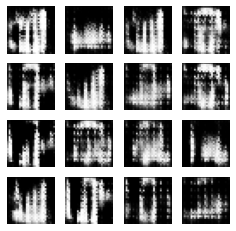

Epoch 7 | iter 151
Time for epoch 7 : 943 sec


In [ ]:
%%time
train(train_dataset, EPOCHS, save_every)